In [1]:
import numpy as np
import matplotlib.pylab as plt
plt.style.use('ggplot')
import time
import scipy.io
from scipy import interpolate
from commands import getoutput as cmd
import scipy.optimize
import shutil
import scipy as sp
from  scipy.ndimage.filters import gaussian_filter

def myfloat(b):
    try: 
        b = float(b)
    except ValueError:        
        b = [b for b in b.split('-') if b]
        b = float(b[0])*10**(-float(b[1]))
    return b


In [2]:
%matplotlib inline

In [3]:
# import python packages and inline animation functions
import matplotlib as mpl
from matplotlib.pylab import plot, pcolor, imshow
from matplotlib import animation

def _blit_draw(self, artists, bg_cache):
    # Handles blitted drawing, which renders only the artists given instead
    # of the entire figure.
    updated_ax = []
    for a in artists:
        # If we haven't cached the background for this axes object, do
        # so now. This might not always be reliable, but it's an attempt
        # to automate the process.
        if a.axes not in bg_cache:
            # bg_cache[a.axes] = a.figure.canvas.copy_from_bbox(a.axes.bbox)
            # change here
            bg_cache[a.axes] = a.figure.canvas.copy_from_bbox(a.axes.figure.bbox)
        a.axes.draw_artist(a)
        updated_ax.append(a.axes)

    # After rendering all the needed artists, blit each axes individually.
    for ax in set(updated_ax):
        # and here
        # ax.figure.canvas.blit(ax.bbox)
        ax.figure.canvas.blit(ax.figure.bbox)

# MONKEY PATCH!!
animation.Animation._blit_draw = _blit_draw
from tempfile import NamedTemporaryFile



VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")

    return VIDEO_TAG.format(anim._encoded_video)

from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))


### Functions for GW

In [4]:
# GW functions
def findh(teq, param):
    # param=[tp,tca,Ksat,I,Ao,Kr_flat]
    tp=param[0]
    tca=param[1]
    Ksat=param[2]
    I=param[3]
    Ao = param[4]
    Kr = param[5]
    res=((I - Ksat)*(teq-tp)-Ao*(np.sqrt(teq-tp+tca)-np.sqrt(tca)))
    return res

def findt(teq,param):
    tp=param[0]
    tca=param[1]
    Ksat=param[2]
    I=param[3]
    Ao = param[4]
    Kr = param[5]
    x= param[6]
    xo = param[7]
    dt =  (teq-tp)/100.
    t = np.arange(tp, teq+dt/10., dt)
    h = ((I - Ksat)*(t-tp)-Ao*(np.sqrt(t-tp+tca)-np.sqrt(tca)))
    h[h<0]=0
    hpower = h**(2./3)
    hint = np.sum((hpower[:-1]+hpower[1:])/2.*(t[1:]-t[:-1]))+\
            hpower[0]/2.*(t[1]-t[0]) + hpower[-1]/2.*(t[-1]-t[-2])
    res=5/3.*Kr*hint-x+xo
    return res


def findtinit(teq,param):
    tpd=param[0]
    tca=param[1]
    Ksat=param[2]
    I=param[3]
    Ao = param[4]
    Kr = param[5]
    L = param[6]
    tp = param[7]  
    dt =  (tpd-teq)/100.
    t = np.arange(teq, tpd+dt/10., dt)
    h = ((I - Ksat)*(t-teq)-Ao*(np.sqrt(t-tp+tca)-np.sqrt(teq-tp+tca)))    
    h[h<0]=0
    hpower = h**(2./3)
    hint = np.sum((hpower[:-1]+hpower[1:])/2.*(t[1:]-t[:-1]))+\
            hpower[0]/2.*(t[1]-t[0]) + hpower[-1]/2.*(t[-1]-t[-2])
               
    res=5/3.*Kr*hint-L
    return res

def findto_out(teq,param):
    to=param[0]
    tca=param[1]
    Ksat=param[2]
    I=param[3]
    Ao = param[4]
    Kr = param[5]
    L= param[6]
    tp=param[7]
    dt = (teq-to)/100.
    t = np.arange(to, teq+dt/10., dt )

    h = (I-Ksat)*(t-to)-Ao*np.sqrt(t-tp+tca)+Ao*np.sqrt(to-tp+tca)
    h[h<0]=0.
    hpower = h**(2./3)
    hint = np.sum((hpower[:-1]+hpower[1:])/2.*(t[1:]-t[:-1]))+\
            hpower[0]/2.*(t[1]-t[0]) + hpower[-1]/2.*(t[-1]-t[-2])

    res=5./3*Kr*hint-L
    return res

def  findt_star(teq,param):
    h_star=param[0]
    Ksat=param[1]
    tpd=param[2]
    Ao=param[3]
    tp=param[4]
    tca=param[5]
    res= h_star-Ksat*(teq-tpd)-Ao*(teq-tp+tca)**(1./2)+Ao*(tpd-tp+tca)**(1./2)
    return res

def findt_cross(teq,param):
    tpd=param[0]
    tca=param[1]
    Ksat=param[2]
    x_star=param[3]
    Ao = param[4]
    Kr = param[5]
    L= param[6]
    tp=param[7]
    h_star=param[8]
    dt = (teq-tpd)/100
    t = np.arange(tpd,teq+dt/10., dt)
    h = h_star-Ksat*(t-tpd)-Ao*np.sqrt(t-tp+tca)+Ao*np.sqrt(tpd-tp+tca)
    h[h<0]=0
    hpower = h**(2./3)
    hint = np.sum((hpower[:-1] +hpower[1:] )/2.*(t[1:]-t[:-1]))+\
                  hpower[0]/2.*(t[1] - t[0])+hpower[-1]/2.*(t[-1]-t[-2])
    res = 5./3*Kr*hint-L+x_star
    return res

In [5]:
def Comparison_function2(I,L,Ksat,Ao,tpd,alpha):
    #   function called as Comparison_function2(I,L,Ksat,Ao,tf,alpha) 
    #   tpd : storm duration (s), tf
    #tpd = tr
    g = 9.81  # m/s^2 Gravity
    dx =  L/500.
    x = np.arange(0, L+dx, dx)
    m = len(x)
    if I > Ksat:
        tp_flat = Ao**2/(I-Ksat)**2
    else:
        tp_flat = tpd*10.

    tca_flat = 1/Ksat**2*(- Ao/2+(Ao**2/4+ I*tp_flat*Ksat)**(1/2.))**2

    if tpd>tp_flat:
        tpd_flat = tpd-tp_flat  #   s      Storm Duration from time of ponding onwards
        # Kr_flat = So**(1/2.)*1./n;  # Manning computation of the resistance
        Kr_flat = alpha           # alpha is the hydraulic resistance 

        [tout_flat,qout_flat] = Steady_flat_w_infil2(I,g,L,tpd,tp_flat,tca_flat,Ksat,Ao,Kr_flat);

    elif tpd<tp_flat:       #  Time of ponding occurs after storm ends!
        qout_flat=np.zeros(100)
        tout_flat = np.arange(1,101)
    ## COMPUTE PARTITIONING
    # Total Rainfall 
    PPT = I*tpd*L     # m^3/m
    # Area under hydrograph
    Q_flat= sum((qout_flat[:-1]+qout_flat[1:])/2.*(tout_flat[1:]-tout_flat[:-1]))+\
            (qout_flat[0]/2.*(tout_flat[1]-tout_flat[0])+ \
            qout_flat[-1]/2.*(tout_flat[-1]-tout_flat[-2]))

    # Percent runoff
    Perc_runoff_flat = Q_flat/PPT
    
    output = np.vstack((tout_flat, qout_flat)).T
    output = output[output[:, 0].argsort()]
    tout = output[:,0]
    qout = output[:,1]

    return [tout,qout,Perc_runoff_flat] 

In [6]:
def Steady_flat_w_infil2(I,g,L,tpd,tp,tca,Ksat,Ao,Kr_flat):
    #  Steady_flat_w_infil2(I,g,L,tpd,tp_flat,tca_flat,Ksat,Ao,Kr_flat);
    # tp = tp_flat
    # tca = tca_flat
    
    x = L
    param=[tp,tca,Ksat,I,Ao,Kr_flat]

    from scipy.optimize import fsolve
    tmin = fsolve(findh, tp, param)[0]
    xo = 0
    param=[tp,tca,Ksat,I,Ao,Kr_flat,x,xo]

    Teq=fsolve(findt,tmin+.1,param)  

    if tpd>Teq:
        T = np.arange(np.ceil(tp), np.round(Teq),(Teq-tp)/100.)
        h = np.ones_like(T)
        q = np.ones_like(T)
        for j in range(len(T)):
            t=T[j]
            h[j]=((I - Ksat)*(t-tp)-Ao*(np.sqrt(t-tp+tca)-np.sqrt(tca)))
            if h[j] < 0:
                h[j] = 0    
            q[j]=Kr_flat*h[j]**(5./3)

        dim = max(np.round(tp)-1, 0)
        q = np.hstack((np.zeros(np.int(dim)), q))
        t1= np.hstack((np.arange(1,np.int(np.round(tp))), T))
        # Domain 2:  Characteristics originating from x=0 for t>Teq
        # Find the last time at which a characteristic originating from x=0 at
        # t>Teq can cross the x=L line before the rainfall ends

        param=[tpd,tca,Ksat,I,Ao,Kr_flat,L,tp]
        tinit = fsolve(findtinit,tp,param)

        To = np.arange( np.round(tp)+1, np.round(tinit),(tinit-tp)/100. )
        to_out = np.ones_like(To)
        h_out = np.ones_like(To)
        q_out = np.ones_like(To)
        for j in range(len(To)):
            to=To[j]
            # Find the value of t at which the characteristic originating at to
            # reaches x = L
            param=[to,tca,Ksat,I,Ao,Kr_flat,L,tp]
            to_out[j] = fsolve(findto_out,tpd,param)
            h_out[j] = (I-Ksat)*(to_out[j]-to)-Ao*(np.sqrt(to_out[j]-tp+tca)-np.sqrt(to-tp+tca))
            q_out[j] = Kr_flat*h_out[j]**(5./3)

        # Domain 3: Characteristics originating from x = 0 which persist into the
        # falling limb of the hydrograph
        dt = (tpd-tinit)/100
        To2 = np.arange(tinit+(tpd-tinit)/100, tpd-(tpd-tinit)/100+ dt/10., dt)
        x_star = np.ones_like(To2)
        h_star = np.ones_like(To2)
        t_star = np.ones_like(To2)
        x_zw = np.ones_like(To2)
        t_cross = np.zeros_like(To2)
        h_cross = np.zeros_like(To2)    
        q_cross = np.zeros_like(To2)        
        for j in range(len(To2)):
            to = To2[j]
            # Find the value of x (x_star) at which the characteristic reaches t = tpd
            dt = (tpd-to)/100.
            t = np.arange(to, tpd + dt/10., dt)

            h = (I-Ksat)*(t-to)-Ao*np.sqrt(t-tp+tca)+Ao*np.sqrt(to-tp+tca)
            hpower = h**(2./3)
            hint = np.sum((hpower[:-1]+hpower[1:])/2.*(t[1:]-t[:-1]))+ \
                    hpower[0]/2.*(t[1]-t[0]) + hpower[-1]/2.*(t[-1]-t[-2])
            x_star[j] = 5./3*Kr_flat*hint
            # Find the value of h (h_star) at this point, (x_star,tpd) on the
            # characteristic originating at to
            h_star[j] = (I-Ksat)*(tpd-to)-Ao*np.sqrt(tpd-tp+tca)+Ao*np.sqrt(to-tp+tca)
            # Now find the value of time where h-h* = 0        
            param = [h_star[j],Ksat,tpd,Ao,tp,tca]
            t_star[j] = fsolve(findt_star,10*tpd,param)
            dt = (t_star[j]-tpd)/100.
            t2 = np.arange(tpd, t_star[j]+ dt/10., dt)
            h2 = h_star[j]-Ksat*(t2-tpd)-Ao*np.sqrt(t2-tp+tca)+Ao*np.sqrt(tpd-tp+tca);
            h2[-1]=0
            hpower2 = h2**(2./3)
            hint2 = np.sum((hpower2[:-1]+hpower2[1:])/2.*(t2[1:]-t2[:-1]))+\
                hpower2[0]/2.*(t2[1]-t2[0])+hpower2[-1]/2.*(t2[-1]-t2[-2])
            x_zw[j] = 5./3*Kr_flat*hint2+x_star[j]
            # If the characteristic crosses L, let's find the time of that crossing
            if x_zw[j]>L:        
                param=[tpd,tca,Ksat,x_star[j],Ao,Kr_flat,L,tp,h_star[j]]
                t_cross[j] = fsolve(findt_cross,(tpd*1.00000001 + t_star[j])/2,param)

                # Now determine the depth of the characteristic crossing L
                h_cross[j]  = h_star[j]-Ksat*(t_cross[j]-tpd)-\
                            Ao*np.sqrt(t_cross[j]-tp+tca)+Ao*np.sqrt(tpd-tp+tca)

                # Now determine the flow associated with this depth
                q_cross[j] = Kr_flat*h_cross[j]**(5./3)
        t_cross = t_cross[t_cross>0]
        q_cross = q_cross[q_cross>0]
        tout = np.hstack((t1, to_out,t_cross))            
        qout = np.hstack((q, q_out,q_cross))
        
    elif tpd<Teq:
        # Up to t = tpd, characteristics originating on t-tp = 0 and x = xo can
        # cross L
        dt = (tpd-tp)/100.
        T = np.arange(round(tp), round(tpd)+dt/10., dt) 
        h = np.ones_like(T)
        q = np.ones_like(T)
        for j in range(len(T)):
            t=T[j]
            h[j]=((I - Ksat)*(t-tp)-Ao*(np.sqrt(t-tp+tca)-np.sqrt(tca)))
            if (h[j])<0:
                h[j]=0.
            q[j]=Kr_flat*h[j]**(5./3)
        q = np.hstack((np.zeros(int(np.round(tp)-1)), q))
        t1 = np.hstack(( np.arange(1,np.round(tp)), T))

        # Find xo for the last catchment that can cross x=L at time < tpd
        dt = (tpd-tp)/100.
        t = np.arange(tp, tpd+dt/10., dt)
        h = ((I - Ksat)*(t-tp)-Ao*(np.sqrt(t-tp+tca)-np.sqrt(tca)))
        h[h<0]=0
        hpower = h**(2./3)
        hint = np.sum((hpower[:-1] + hpower[1:])/2.*(t[1:] - t[:-1]))+\
                hpower[0]/2.*(t[1]-t[0])+hpower[-1]/2.*(t[-1]-t[-2])
        xo = L - 5./3*Kr_flat*hint
        # for xo located between o and xo, characteristics evolve to a point at
        # time tpd, and then decay.
        XO = np.arange(0, xo + xo/1000., xo/100.)  
        x_star = np.zeros_like(XO[:-1])
        h_star = np.zeros_like(XO[:-1])
        t_star = np.zeros_like(XO[:-1])
        x_zw = np.zeros_like(XO[:-1])
        t_cross = np.zeros_like(XO[:-1])
        h_cross = np.zeros_like(XO[:-1])
        q_cross = np.zeros_like(XO[:-1])
        for j in range(len(XO)-1):
            xo = XO[j]
            dt = (tpd-tp)/100.
            t = np.arange(tp, tpd + dt/10., dt)

            h = (I-Ksat)*(t-tp)-Ao*np.sqrt(t-tp+tca)+Ao*np.sqrt(tca)
            h[h<0] = 0.
            hpower = h**(2./3)
            hint = np.sum((hpower[:-1]+hpower[1:])/2.*(t[1:]-t[:-1]))+\
                     + hpower[0]/2.*(t[1]-t[0]) + hpower[-1]/2.*(t[-1]-t[-2])
            x_star[j] = xo + 5./3*Kr_flat*hint

            # So at tpd, the characteristic is at xstar.
            # Find the value of h (h_star) at this point, (x_star,tpd) on the
            # characteristic originating at to
            h_star[j] = (I-Ksat)*(tpd-tp)-Ao*np.sqrt(tpd-tp+tca)+Ao*np.sqrt(tca)

            if h_star[j]>0:
                # Now find the value of time where h-h* = 0
                param=[h_star[j],Ksat,tpd,Ao,tp,tca]
                t_star[j] = fsolve(findt_star,0.95*tpd,param)
                dt = (t_star[j]-tpd)/100.
                t2 = np.arange(tpd, t_star[j]+dt/10., dt)
                h2 = h_star[j]-Ksat*(t2-tpd)-Ao*np.sqrt(t2-tp+tca)+\
                        Ao*np.sqrt(tpd-tp+tca)
                h2[-1]=0
                hpower2 = h2**(2./3)
                hint2 = sum((hpower2[:-1]+hpower2[1:])/2.*(t2[1:]-t2[:-1]))+\
                        hpower2[0]/2.*(t2[1]-t2[0])+hpower2[-1]/2.*(t2[-1]-t2[-2])
                x_zw[j] = 5./3*Kr_flat*hint2+x_star[j]   

                # If the characteristic crosses L, let's find the time of that crossing
                if x_zw[j] > L*1.01: 
                    param=[tpd,tca,Ksat,x_star[j],Ao,Kr_flat,L,tp,h_star[j]]
                    t_cross[j] = fsolve(findt_cross,tpd*1.00000000001,param)

                    # Now determine the depth of the characteristic crossing L
                    h_cross[j] = h_star[j]-Ksat*(t_cross[j]-tpd)-Ao*\
                                np.sqrt(t_cross[j]-tp+tca)+Ao*np.sqrt(tpd-tp+tca)

                    # Now determine the flow associated with this depth
                    q_cross[j] = Kr_flat*h_cross[j]**(5./3)
                else: 
                    h_cross[j]=0
                    q_cross[j]=0
                    x_zw[j]=0


        if len(np.where(x_zw>L*1.01)[0])>=1:
            tout = np.hstack((t1, t_cross))
            qout = np.hstack((q, q_cross))
        else:
            tout=t1 
            qout=q
    return tout,qout
                

### Functions to write the input files for dry.f

In [7]:
def write_prate(folder = 'test', tmax = 100, dt_sw = 1., rain = 0.036/3600.):
    t = np.arange(0., tmax + dt_sw, dt_sw)
    nt_sw = t.shape[0]-1
    prate = np.ones_like(t)*rain
    prate[np.where(t>=tr)[0][0]:] = 0

    f = open('{0}/prate.dat'.format(folder), 'w')

    f.write('{0:<13} \n'.format(nt_sw))
    for n in range( nt_sw +1):
        f.write('{0} {1} \n'.format(t[n], prate[n])) 

    f.close()
    return nt_sw

# nt_sw = write_prate(folder = folder, tmax = tmax, dt_sw = dt_sw, rain = rain)

In [8]:
def write_coords(folder = 'test', ncol = 2, nrow = 2, dx = 1, 
                 slope = 0., xni = 0.03, xnv = 0.03, seed = 0 ):        
    np.random.seed(seed)
    npt = (ncol+1)*(nrow+1)  # number of points
    ne = nrow*ncol  # number of edges
    nbcell = 2*ncol + 2*nrow - 4  # number of boundary cells

    xdum = np.arange(0, (ncol+1)*dx - 1e-10, dx )
    ydum = np.arange(0, (nrow+1)*dx - 1e-10, dx )
    ydum, xdum = np.meshgrid(ydum, xdum)

    zymax = slope*(np.max(ydum) - np.min(ydum))
    zxmax = slope*(np.max(xdum) - np.min(xdum))/4.
    topo = 'slope'

    if topo == 'gnoise': 
        rowNoise = sp.randn(nrow+1)/20.
        rowGauss =  gaussian_filter(rowNoise, 5, order=1, \
                                output=None, cval=0.0, truncate=20.0)
        zrow = rowGauss + np.linspace(0,zymax, nrow+1)

        colNoise = sp.randn(ncol+1)/20.
        colGauss =  gaussian_filter(colNoise, 2, order=1, \
                                output=None, cval=0.0, truncate=20.0)
        zcol = colGauss + np.abs(np.linspace(-zxmax, zxmax, ncol+1))

        zrow2 = np.tile(zrow, [ncol+1]).reshape([ncol+1, nrow+1])
        zcol2 = np.tile(zcol, [nrow+1]).reshape([nrow+1, ncol+1])

        zdum = zrow2 + 0*zcol2.T

        # zdum[:, 0] = zdum[:, 1] - slope
        
    if topo == 'slope':
        zrow =  np.linspace(0,zymax, nrow+1)
        zrow2 = np.tile(zrow, [ncol+1]).reshape([ncol+1, nrow+1])
        zdum = zrow2 

    if topo == 'sine':
        zrow =  np.linspace(0,1, nrow+1)
        zrow = zymax*np.sin(zrow*2*np.pi/4)
        zrow2 = np.tile(zrow, [ncol+1]).reshape([ncol+1, nrow+1])
        zdum = zrow2     
    
    plt.pcolor(zdum)
    xndum = np.ones_like(zdum)*xni    
    xndum[:, :nrow/2]  = xnv
    isveg_dum = np.zeros_like(zdum)
    
    x = np.zeros(npt + 1)
    y = np.zeros(npt + 1)
    z = np.zeros(npt + 1)
    xn = np.zeros(npt + 1)
    isveg = np.zeros(npt + 1)

    x[1:] = xdum.ravel()
    y[1:] = ydum.ravel()
    z[1:] = zdum.ravel()
    xn[1:] = xndum.ravel()
    isveg[1:] = isveg_dum.ravel()

    # print (np.max(zdum) - np.min(zdum))/(np.max(ydum) - np.min(ydum))*100
    # (ncol+1) by (nrow+1)  -  node numbers
    nodes = np.arange(1, npt+1, dtype = int).reshape([ncol+1, nrow+1])

    nop = np.zeros([ncol+1, nrow+1, 4], dtype = int)
    for j in range(ncol):
        for k in range(nrow):
            nop[j+1, k+1] =  nodes[j,k], nodes[j+1, k], nodes[j+1,k+1], nodes[j,k+1]
           

    fname = '{0}/coords.dat'.format(folder)
    f = open(fname, 'w')
    f.write('{0:<13}   {1:<13}\n'.format(npt, ne))

    # write x, y, z
    for n in range(1, npt+1):
        f.write('{0:<13.6f} {1:<13.6f} {2:<13.6f} {3:<13.6e} {4:<13.6e}  \n'.format(
                    x[n],y[n],z[n],xn[n],isveg[n])) 

    # write node numbers  
    for j in range(1, ncol+1):
        for k in range(1, nrow+1):
            n1 = nop[j, k, 0] 
            n2 = nop[j, k, 1]       
            n3 = nop[j, k, 2]        
            n4 = nop[j, k, 3] 
            f.write('{0:<10} {1:<10}  {2:<10} {3:<10}\n'.format(n1, n2, n3, n4)) 
    f.close()  

    # get cell center values:
    xcc  = np.zeros([ncol+2, nrow+2])    
    ycc  = np.zeros([ncol+2, nrow+2])
    zcc  = np.zeros([ncol+2, nrow+2])
    xncc  = np.zeros([ncol+2, nrow+2])

    for j in range(1, ncol+1):
        for k in range(1, nrow+1):
            n1 = nop[j, k, 0] 
            n2 = nop[j, k, 1]       
            n3 = nop[j, k, 2]        
            n4 = nop[j, k, 3]  
            xcc[j,k] = 0.25*(x[n1] + x[n2] + x[n3] + x[n4])  
            ycc[j,k] = 0.25*(y[n1] + y[n2] + y[n3] + y[n4])
            zcc[j,k] = 0.25*(z[n1] + z[n2] + z[n3] + z[n4])   
            xncc[j,k] = 0.25*(xn[n1] + xn[n2] + xn[n3] + xn[n4])   
                
    return xcc[1:-1, 1:-1], ycc[1:-1, 1:-1], zcc[1:-1, 1:-1], xncc[1:-1, 1:-1]


In [9]:
def write_param(folder = 'test',  dt= 1, 
                 tmax = 100,  nprt = 1, epsh = 0.0025,
                 iscale= 1, ifixh = 0, stop_tol = 1e-5, depth = 0.,
                beta = 1.0):
    
    fname = '{0}/params.dat'.format(folder)    
    f = open(fname, 'w')
    f.write('gravity     dt        tmax    \n')
    f.write('9.806d0     {0}       {1}     \n'.format(dt, tmax))
    f.write(' epsh      beta     \n')  
    f.write('{0}        {1}     \n'.format(epsh, beta))
    f.write('xk          nprt      \n')
    f.write('3.9217d-4   {1}       \n'.format(tr, int(nprt)))   
    f.write(' iscouple    ifixh \n')
    f.write(' {0}        {1} \n'.format( iscouple, ifixh))   
    f.write(' iscale   \n')
    f.write(' {0}       \n'.format( iscale))  
    f.write(' stop_tol   \n')
    f.write(' {0}       \n'.format( stop_tol))      
    f.write('h0      u0    v0   \n ')
    f.write('{0}    0.0    0.0  \n '.format(depth))
    f.close()


In [10]:
def write_dryin(folder = 'test', ncol = 2, nrow = 2):
    inum = np.zeros([ncol+1, nrow+1], dtype = int)
    inum[1:, 1] = 1
    inum[1:, -1]= 1
    inum[1, 1:] = 1
    inum[-1, 1:] = 1
    inum[1, 1] = 2
    inum[1, -1] = 2
    inum[-1, -1] = 2
    inum[-1, 1] = 2
    
    ipos = np.zeros( [ncol+1, nrow+1, 2], dtype = int)
    # bottom boundary
    ipos[2:-1, 1,0] = 1
    ipos[1, 1,1] = 1
    ipos[-1, 1,1] = 1

    # right boundary
    ipos[-1, 1:-1, 0] = 2
    ipos[-1, -1,1] = 2

    # left boundary
    ipos[1, 1:, 0] = 4

    # top boundary
    ipos[2:, -1,0] = 3
    ipos[1, -1,1] = 3
    
    itype = np.zeros([ncol+1, nrow+1, 2], dtype = int)
    # bottom boundary
    itype[2:-1, 1,0] = 0
    itype[1, 1,1] = 0
    itype[-1, 1,1] = 0

    # right boundary
    itype[-1, 1:-1, 0] = 1
    itype[-1, -1,1] = 1

    # left boundary
    itype[1, 1:,0] = 1

    # top boundary
    itype[2:, -1,0] = 1
    itype[1, -1,1] = 1
    
    npt = (ncol+1)*(nrow+1)  # number of points
    ne = nrow*ncol  # number of edges
    nbcell = 2*ncol + 2*nrow - 4  # number of boundary cells
    
    fname = '{0}/boundary.dat'.format(folder)    
    f = open(fname, 'w')
    f.write('number of boundary cell \n') 
    f.write('  {0} \n'.format(nbcell))
    f.write(' j    k          inum    itype             ipos \n')
    # f.write(' j \t k \tinum    itype \t\t ipos')
    j = 1
    for k in range(1, nrow+1):
        if inum[j, k] == 2:
            f.write( '{0:<5} {1:<13} {2:<7} {3:<8} {4:<9} {5:<8} {6:<6} \n'.format(
                        j, k, inum[j, k], itype[j, k, 0], itype[j, k, 1], 
                         ipos[j, k, 0], ipos[j, k, 1]))
        else:
            f.write( '{0:<5} {1:<13} {2:<7} {3:<18} {4:<10}   \n'.format(
                         j, k, inum[j, k],  itype[j, k, 0],  ipos[j, k, 0], ))

    for j in range(2, ncol+1):
        if inum[j, k] == 2:
            f.write( '{0:<5} {1:<13} {2:<7} {3:<8} {4:<9} {5:<8} {6:<6} \n'.format(
                        j, k, inum[j, k], itype[j, k, 0], itype[j, k, 1], 
                         ipos[j, k, 0], ipos[j, k, 1]))
        else:
            f.write( '{0:<5} {1:<13} {2:<7} {3:<18} {4:<10}   \n'.format(
                         j, k, inum[j, k],  itype[j, k, 0],  ipos[j, k, 0], ))

    for k in range(nrow-1,0,-1):
        if inum[j, k] == 2:
            f.write( '{0:<5} {1:<13} {2:<7} {3:<8} {4:<9} {5:<8} {6:<6} \n'.format(
                        j, k, inum[j, k], itype[j, k, 0], itype[j, k, 1], 
                         ipos[j, k, 0], ipos[j, k, 1]))
        else:
            f.write( '{0:<5} {1:<13} {2:<7} {3:<18} {4:<10}   \n'.format(
                         j, k, inum[j, k],  itype[j, k, 0],  ipos[j, k, 0], ))
            
    for j in range(ncol-1,1,-1):
        if inum[j, k] == 2:
            f.write( '{0:<5} {1:<13} {2:<7} {3:<8} {4:<9} {5:<8} {6:<6} \n'.format(
                        j, k, inum[j, k], itype[j, k, 0], itype[j, k, 1], 
                         ipos[j, k, 0], ipos[j, k, 1]))
        else:
            f.write( '{0:<5} {1:<13} {2:<7} {3:<18} {4:<10}   \n'.format(
                         j, k, inum[j, k],  itype[j, k, 0],  ipos[j, k, 0], ))

    kbeg = np.ones(ncol+1, dtype = int)
    kend = np.ones(ncol+1, dtype = int)*nrow
   
    f.write('ncol\n')
    f.write("{0}\n".format(ncol))
    f.write('nrow\n')
    f.write("{0}\n".format(nrow))    
    f.write('j     kbeg          kend \n')
    for j in range(1, ncol+1):
        f.write( '{0:>5}  {1:>5} {2:>13}   \n'.format(
                    j, kbeg[j],kend[k] ))

    f.close()
    return inum, ipos, itype

### Function to create phi and write it to a file:

In [11]:
def write_phi(folder = 'test', dz = 0.2, zmin = 0, zmax = 20, z = 0, zs = 4,
             infL = 2):
        # Define van Genuchten parameters
        # veg areas / below the seal layer
        vegAlpha   = 0.0096  
        vegTheta_S = 0.472  
        vegTheta_R = 0.0378  
        vegLambdA  = 0.318 
        vegn       = vegLambdA + 1
        vegm       = vegLambdA/vegn
        vegKsat    = 3.38/3600. 

        # Seal layer
        sealAlpha   = 0.0078  
        sealTheta_S = 0.450  
        sealTheta_R = 0.0394  
        sealLambdA  = 0.263  
        sealn       = sealLambdA + 1
        sealm       = sealLambdA/sealn
        sealKsat    = 0.19/3600. 
    
        si = np.where(z == z[-1] - zs)[0][0]  
        nz = z.shape[0]
        alpha = np.ones(nz)*vegAlpha
        theta_S = np.ones(nz)*vegTheta_S
        theta_R = np.ones(nz)*vegTheta_R
        lambdA = np.ones(nz)*vegLambdA
        ksat = np.ones(nz)*vegKsat

        alpha[si:] = sealAlpha
        theta_S[si:] = sealTheta_S
        theta_R[si:] = sealTheta_R
        lambdA[si:] = sealLambdA
        ksat[si:] = sealKsat

        n = lambdA + 1
        m = lambdA/n
        
        phi = {'alpha': alpha,
               'theta_R': theta_R,
               'theta_S': theta_S,
               'theta_S': theta_S,
               'lambdA': lambdA,
               'n': n, 
               'm': m, 
               'ksat': ksat,
              }
        
        f = open('{0}/vanG.dat'.format(folder), 'w')
        f.write('infL \n')  
        f.write('{0:<13}  \n'.format(infL))
        f.write('dz zmax \n')  
        f.write('{0:<13} {1:<13}  \n'.format(dz, zmax))
        f.write('nz \n')  
        f.write('{0:<13}  \n'.format(nz))
        for n in range(nz):
            f.write('{0} {1} {2} {3} {4} {5} \n'.format(alpha[n],theta_S[n], 
                                        theta_R[n],lambdA[n],ksat[n],hinit[n])) 
        f.close()
        
        return phi

### Function to avoid allocating to much space 

In [12]:
def write_inc(folder= 'test', nt = 100, nz = 101, ncol = 2, nrow = 2):
    #  Avoid allocating to much space 

    with open('dry0.inc', 'r') as input_file, open('{0}/dry.inc'.format(folder), 'w') as output_file:
        for line in input_file:
            if line[6:15] == 'parameter':
                # print 'old line:', line
                a = (line.strip().split(" ")[2].split(","))
                nn0 = int(a[0].split('=')[-1])
                nt0 = int(a[1].split('=')[-1])
                nx0 = int(a[2].split('=')[-1])
                ny0 = int(a[3].split('=')[-1])
                nz0 = int(a[4].split('=')[-1])

                newline = '      parameter ( nn={0},ntp={1},nx={2},ny={3},nz={4} )'.format(
                     (ncol+1)*(nrow+1)+1, nt+1, ncol+2, nrow+2, nz)

                #newline = '      parameter ( nn={0},ntp={1},nx={2},ny={3},nz={4} )'.format(
                #     nn0, nt0, nx0, ny0, nz)

                #print 'new line:', newline
                output_file.write(newline)
            else:
                output_file.write(line)


###  Richards functions

In [13]:
def vanGenuchten(h,phi) :
    alpha   = phi['alpha']
    theta_S = phi['theta_S']
    theta_R = phi['theta_R']
    n       = phi['n']
    m       = phi['m']
    Ksat    = phi['ksat'] 
    # Compute the volumetric moisture content
    theta = (theta_S - theta_R)/(1 + (alpha*abs(h))**n)**m + theta_R
    # Compute the effective saturation
    Se = ((theta - theta_R)/(theta_S - theta_R))
    # Compute the hydraulic conductivity
    K = Ksat*Se**(1./2)*(1 - (1 - Se**(1./m))**m)**2
    # Compute the specific moisture storage
    C =  -alpha*n*np.sign(h)*(1./n - 1)*(alpha*abs(h))**(n - 1)*(theta_R - 
         theta_S)*((alpha*abs(h))**n + 1)**(1/n - 2)
    try:
        for i in range(len(h)):
            if h[i] > 0:
                K[i] = Ksat[i]
                C[i] = 0.
                theta[i] = theta_S[i]
    except TypeError:
        if h > 0:
            K = Ksat[i]
            C = 0.
            theta = theta_S[i]
    return [C,K,theta]

In [14]:
def Richards_matrices(nz, infL = 2):
    # Define matrices that we'll need in solution
    DeltaPlus  = np.diag(-np.ones(nz)) + np.diag(np.ones(nz-1), 1)
    DeltaPlus[0,:] = 0
    DeltaPlus[nz-1,:] = 0

    DeltaMinus = np.diag(np.ones(nz)) + np.diag(-np.ones(nz-1),-1);
    DeltaMinus[0,:] = 0
    DeltaMinus[nz-1,:] = 0

    MPlus = np.diag(np.ones(nz))+np.diag(np.ones(nz-1),1)
    MPlus[0,0] = 2
    MPlus[0,1:nz-1] = 0
    MPlus[nz-1,nz-1] = 2
    MPlus[nz-1,:nz-1] = 0

    MMinus = np.diag(np.ones(nz)) + np.diag(np.ones(nz-1),-1)
    MMinus[0,0] = 2
    MMinus[0,1:nz-1] = 0 
    MMinus[nz-1,nz-1] = 2
    MMinus[nz-1,:nz-1] = 0 

    if infL == 2:
        MPlus[-2, -2] = 2
        MPlus[-2, -1] = 0
        
    return DeltaPlus, DeltaMinus, MPlus, MMinus

In [15]:
 def pot_infl(hnp1m, thetan, htop = 0, infL = 2, stop_tol = 1e-5, inv = 0):
    
    stop_flag = 0
    niter = 0

    while(stop_flag == 0):
        [cnp1m,knp1m,thetanp1m] = vanGenuchten(hnp1m,phi)
        Cdiag = np.diag(cnp1m) 
        kbarplus = (1/2.)*MPlus.dot(knp1m)
        Kbarplus = np.diag(kbarplus)
        kbarminus = (1/2.)*MMinus.dot(knp1m)
        Kbarminus = np.diag(kbarminus)
        A = (1./dt)*Cdiag - 1./((dz)**2)*(Kbarplus.dot(DeltaPlus) - 
                                          Kbarminus.dot(DeltaMinus)) 
        #  Compute the residual of MPFD (RHS)
        R_MPFD = (1./(dz**2))*(Kbarplus.dot(DeltaPlus).dot(hnp1m) - \
                               Kbarminus.dot(DeltaMinus).dot(hnp1m)) + \
             (1./dz)*(kbarplus - kbarminus) - (1./dt)*(thetanp1m - thetan); 
        # Compute deltam for iteration level m+1

        if inv == 0:
            Ainv = np.linalg.pinv(A)
        
        elif inv == 1:
            Ainv = np.linalg.inv(A)
            
        deltam = Ainv.dot(R_MPFD)

        # Increment iteration counter and display number of iterations
        niter = niter + 1;
        if niter > 100.:
            stop_tol = stop_tol*10.
            niter = 0 
        if (max(abs(deltam[1:(nz-1)]))<stop_tol):

            stop_flag = 1
            hnp1mp1 = hnp1m + deltam 
            hnp1mp1[0] = hnp1mp1[1]  # free drainage BC
            hnp1mp1[-1] = htop
            [cnp1m,knp1m,thetanp1m] = vanGenuchten(hnp1mp1,phi);
            knp1mp1 = knp1m
            cnp1mp1 = cnp1m            
            hnp1m = hnp1mp1
            kt = (knp1mp1[-infL] + knp1mp1[-2])/2.
            PI = kt*((hnp1mp1[-1] - hnp1mp1[-2])/dz + 1.)
        else:
            hnp1mp1 = hnp1m + deltam
            hnp1m = hnp1mp1
            hnp1m[0] = hnp1m[1] 
            hnp1m[-1] = htop
    return PI

In [16]:
def timestep(hnp1m, thetan, setflux = 1, flux = 0, htop = 0., infL = 2,
              stop_tol = 1e-5, inv = 0):
    """"""
    stop_flag = 0
    niter = 0
    while(stop_flag == 0):
        [cnp1m,knp1m,thetanp1m] = vanGenuchten(hnp1m,phi)
        Cdiag = np.diag(cnp1m) 
        kbarplus = (1/2.)*MPlus.dot(knp1m)
        Kbarplus = np.diag(kbarplus)
        kbarminus = (1/2.)*MMinus.dot(knp1m)
        Kbarminus = np.diag(kbarminus)
        A = (1./dt)*Cdiag - 1./((dz)**2)*(Kbarplus.dot(DeltaPlus) - 
                                          Kbarminus.dot(DeltaMinus)) 
        R_MPFD = (1./(dz**2))*(Kbarplus.dot(DeltaPlus).dot(hnp1m) - \
                               Kbarminus.dot(DeltaMinus).dot(hnp1m)) + \
                 (1./dz)*(kbarplus - kbarminus) - (1./dt)*(thetanp1m - thetan) 

        if inv == 0:
            Ainv = np.linalg.pinv(A)
            
        elif inv == 1:
            Ainv = np.linalg.inv(A)
            
            
        deltam = Ainv.dot(R_MPFD)
        niter = niter + 1
        if niter > 100.:
            stop_tol = stop_tol*10.
            niter = 0        
            # print 'niter > 100, stop_tol increased to ', stop_tol
        if (max(abs(deltam[1:-1]))<stop_tol):
            stop_flag = 1
            hnp1mp1 = hnp1m + deltam 
            hnp1mp1[0] = hnp1mp1[1]  # free drainage BC
            if setflux == 1:                
                kt = (knp1m[-infL] + knp1m[-2])/2.
                hnp1mp1[-1] =  hnp1mp1[-2] - dz - flux*dz/kt
            else:
                hnp1mp1[-1] = htop
    
            [cnp1m, knp1m,thetanp1m] = vanGenuchten(hnp1mp1,phi);
            knp1mp1 = knp1m
            cnp1mp1 = cnp1m  
            hnp1m = hnp1mp1
 
        else:      
            hnp1mp1 = hnp1m + deltam
            hnp1m = hnp1mp1
            hnp1m[0] = hnp1m[1] 
            if setflux == 1:            
                kt = (knp1m[-infL] + knp1m[-2])/2.
                hnp1m[-1] = hnp1m[-2] - dz - flux*dz/kt
            else:
                hnp1m[-1] = htop
                     
    errornp1 =  np.sum((A.dot(deltam)))*dt*dz
    return hnp1mp1,cnp1mp1,knp1mp1, thetanp1m, errornp1, niter, stop_tol

In [17]:
def Richards(hinit, phi, nz = 101, nt= 100, depth = 0, infL = 2,
             stop_tol = 1e-5, htop = 0, ifixh = 0):

    # Define a storage container to store the pressure heads and soil moistures
    [Cinit,Kinit,thetainit] = vanGenuchten(hinit,phi) 
    H = np.zeros([nz,nt+1])
    H[:,0] = hinit
    THETA = np.zeros([nz,nt+1])
    THETA[:,0] = thetainit
    K = np.zeros([nz,nt+1])
    K[:,0] = Kinit

    depths = np.zeros([nt])
    iterations = np.zeros([nt])
    ktop = np.zeros([nt])
    kbot = np.zeros([nt])
    error = np.zeros([nt])
    iterations = np.zeros([nt])
    # Define the container for an iteration counter
    tp = 0
    start_time = time.time()

    # Initialize the Picard iteration solver
    for i in range(0, nt): 

        hnp1m =  H[:,i]  
        thetan = THETA[:,i]   
        if ifixh == 1 :
            hnp1mp1,cnp1mp1,knp1mp1, thetanp1mp1, errornp1,niter,tol = \
                        timestep(hnp1m,thetan,setflux=0,
                                 htop=htop,stop_tol=stop_tol, infL = infL)
    
        elif (depth <= 0) and (prate[i] > 0):
            PI = pot_infl(hnp1m, thetan, htop = htop, infL = infL, 
                          stop_tol = stop_tol)
            
            if  PI < prate[i]:
                if tp == 0:
                    print 'ponding at time t=', t[i]
                    tp = i
                flux = - PI
                hnp1mp1,cnp1mp1,knp1mp1,thetanp1mp1,errornp1,niter,tol  = \
                        timestep(hnp1m, thetan, setflux = 0, 
                        htop = htop, stop_tol=stop_tol, infL = infL)
                if ponding == 1:
                    depth += prate[i]*dt + flux*dt
            else:
                flux = - prate[i]
                hnp1mp1,cnp1mp1,knp1mp1,thetanp1mp1,errornp1,niter,tol  = \
                   timestep(hnp1m,thetan, setflux = 1, flux = flux, 
                            stop_tol=stop_tol, infL = infL)

        elif (depth <= 0) and (prate[i] == 0):   
            hnp1mp1,cnp1mp1,knp1mp1,thetanp1mp1,errornp1,niter,tol = \
               timestep(hnp1m,thetan, setflux = 1, flux = 0., 
                        stop_tol=stop_tol, infL = infL)                

        elif (depth > 0):  
            hnp1mp1,cnp1mp1,knp1mp1,thetanp1mp1,errornp1,niter,tol  = \
                            timestep(hnp1m,thetan, setflux=0, htop = depth, 
                                     stop_tol=stop_tol, infL = infL)
            kt = (knp1mp1[-infL] + knp1mp1[-2])/2.       
            if ponding == 1:
                depth +=  prate[i]*dt - kt*((hnp1mp1[-1] - hnp1mp1[-2])/dz + 1.)*dt 

        if depth <0.:
            depth = 0.

        THETA[:,i+1] = thetanp1mp1
        H[:,i+1] = hnp1mp1
        K[:,i+1] = knp1mp1

        kbot[i] =  (K[1, i+1] + K[0, i+1])/2.  
        ktop[i] =  (K[-infL, i+1] + K[-2, i+1])/2.  
        error[i] = errornp1
        iterations[i] = niter
        depths[i] = depth

        if np.mod(i,1) == 10:  
            if ifixh == 1:
                print 't = {0:.2f}; '.format( t[i])

            elif prate[i] > 0:
                print 't = {0:.2f}; depth = {1:.2f}cm; PI = {2:.2f}cm/hr; rain = {3:.2f}cm/hr '.format(
                     t[i], depth, PI*3600,prate[i]*3600)
            else:
                print 't = {0:.2f}; depth = {1:.2f}cm;  '.format(
                     t[i], depth)

    t_elapse = (time.time() - start_time)
    
    newmass =  (THETA[:, 1:] - THETA[:, :-1]).sum(0)*dz   #  change in mass      

    H = H[:, 1:]
    THETA = THETA[:, 1:]
    K = K[:, 1:]
    fluxin = ktop*((H[-1]-H[-2])/dz + 1.)*dt   # top flux (cm)
    fluxout = - kbot*((H[1] - H[0])/dz + 1. )*dt # bottom flux (cm)

    return H, THETA, K, fluxin, fluxout, newmass, error, depths, t_elapse

##  specify parameters

In [18]:
case = 'GW'

In [19]:
if case == 'GW':

    # SW grid and params
    ncol  = 2
    nrow  = 60
    slope  = 0.01
    dx  = .5
    L = nrow*dx  # m
    xni  = 0.03      # interspace roughness  (Manning's n)
    xnv  = 0.03
    epsh  = .0002
    beta  = 2.0
        
    # time grids and params
    dt_sw  = .01
    iscale = 100
    tmax  = 60*60.  
    tr  = 35*60.                    # rainfall duration
    rain = 0.036/3600. # 36 mm/hr
    nprt = int(4/dt_sw)
    seed = 5
    
    # Richards params
    iscouple  = 1
    ifixh = 0
    zs = 20

    alpha = np.sqrt(slope)/xni # [m^(1/3)/s]  sqrt(So)/n
    Ao = .006/100. #Ao = np.sqrt(355.*2/1000000/3600)  # m/s^(1/2)  Sorptivity  
    
    if iscouple:
        folder = 'GW'
    else:
        folder = 'slope'
    cmd('mkdir {0}'.format(folder))
    print folder


GW


In [20]:
if case == 'richards':
    folder = 'richards'
    cmd('mkdir {0}'.format(folder))
    print  'coupled, richards solver'
    ncol = 2
    nrow = 2
    slope = 0.
    dx  = .5
    L = nrow*dx  # m
    xni  = 0.03      # interspace roughness  (Manning's n)
    xnv  = 0.03
    epsh = .0002
    beta = 1.0

    # time grids and params
    dt_sw = 1  
    iscale = 10    
    tmax = 19*60
    tr = 10*60                   # rainfall duration
    rain = 0.036/3600. # 36 mm/hr    
    nprt = 1  
    seed = 5
    
    # Richards params
    iscouple = 1
    ifixh = 0
    zs = 4   # depth of seal layer in cm  (zs = 0 if no seal, zmax if all sea;)

In [21]:
if case == 'fixed_h':
    print  'fixed h'
    folder = 'fixed_h'
    cmd('mkdir {0}'.format(folder))
    
    ncol = 2
    nrow = 2
    dt_sw = 1  # define two time grids
    iscale = 1
    tmax = 200
    tr = 100
    rain = 0.036/3600. # 36 mm/hr    
    nprt = 1  
    # SW parameters
    slope =  0.0
    dx = .5
    xni = 0.03                # interspace roughness  (Manning's n)
    epsh = .0025
    slope =  0.0
    # Richards params    
    iscouple = 1
    ifixh = 1
    zs = 20

In [22]:
# Richards parameters
stop_tol = 1e-1  # Stopping tolerance [cm]
inv = 0
htop = 0
infL = 2
ponding = 1 

dz = .2 # [cm]
zmin = 0. # [cm]
zmax = 20. # [cm]
z = np.arange(zmin, zmax+dz, dz)
nz = z.shape[0]

hinit = -100*np.ones(nz)
depth = 0. # cm
    
phi = write_phi(folder = folder, dz = dz, zmin = zmin, zmax = zmax,  z = z,
                    zs = zs, infL = infL)

# Time parameters for python
dt = dt_sw*iscale
t = np.arange(0, tmax + dt, dt)
prate = np.ones_like(t)*rain*100.
prate[np.where( t>= tr)[0][0]:] = 0
t = t[1:]
nt = t.shape[0] 



In [23]:
stop_tol

0.1

In [24]:
if iscouple==1:
    fmtstr = 'coupled,stop_tol={4},slope={0}%,beta={1},epsh={2}mm,dt={3}s'.format(
        slope*100,beta,epsh*1000, dt_sw, stop_tol)    
else:
    fmtstr = 'uncoupled,slope={0}%,beta={1},epsh={2}mm,dt={3}s'.format(
        slope*100,beta,epsh*1000, dt_sw)
print fmtstr

subfolder = '{0}/{1}'.format(folder, fmtstr)
cmd('mkdir {0}'.format(subfolder))
   

coupled,stop_tol=0.1,slope=1.0%,beta=2.0,epsh=0.2mm,dt=0.01s


''

In [25]:
[Cinit,Kinit,thetainit] = vanGenuchten(hinit,phi) 
Ksat=phi['ksat'][-1]/100.
Ao = np.sqrt(2*(1-1/phi['n'][-1])**(4/3.)*Kinit[-1]*
             (phi['theta_S'][-1]-phi['theta_R'][-1])/phi['alpha'][-1])/100.
[tout,qout,Perc_runoff] = Comparison_function2(rain,L,Ksat,Ao,
                                               tr,alpha)
# import scipy.io as sio
# qmat = sio.loadmat('GWmatlab/qout.mat')
# tmat = qmat['tout']
# qmat = qmat['qout']

# plt.plot(tout/60.,qout*3600*24*L, '--');
# plt.plot(tmat/60., qmat*3600*24*L);
# plt.xlabel('time, s')
# plt.ylabel('flow, m^3/day')


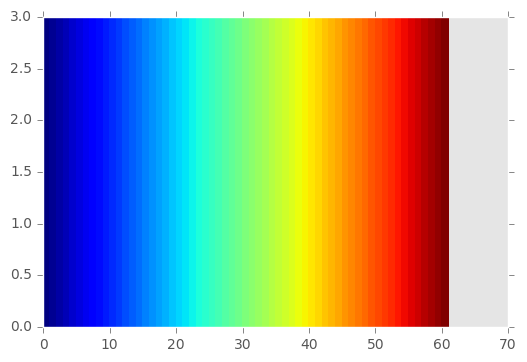

In [26]:
### Call functions to write input files for dry.f
nt_sw = write_prate(folder = folder, tmax = tmax, dt_sw = dt_sw, rain = rain)

xcc,ycc,zcc, xncc =write_coords(folder = folder,ncol = ncol, nrow = nrow,
                                   dx = dx, slope = slope, xni = xni, xnv = xnv)


write_param(folder = folder, dt = dt_sw, tmax = tmax, nprt = nprt, epsh = epsh,
                beta = beta, iscale=iscale, ifixh = ifixh, stop_tol=stop_tol, 
            depth = depth/100.)

inum, ipos, itype = write_dryin(folder = folder, ncol = ncol, nrow = nrow)



In [27]:
# plt.plot(zcc[1, :])

In [28]:
DeltaPlus, DeltaMinus, MPlus, MMinus = Richards_matrices(nz, infL = infL)
write_inc(folder = folder, nt = nt_sw, nz = nz,  ncol = ncol, nrow = nrow)

In [29]:

shutil.copyfile('dry2.for', '{0}/dry.for'.format(folder))
print 'cp dry.for', '{0}/dry.for'.format(folder)



### Run fortran code
a = cmd("gfortran -o {0}/sw  -framework accelerate {0}/dry.for".format(folder))
print "gfortran -o {0}/sw  -framework accelerate {0}/dry.for".format(folder)
print a

cp dry.for GW/dry.for
gfortran -o GW/sw  -framework accelerate GW/dry.for



In [30]:
runInNotebook = 1
if runInNotebook :
    import os 
    start_time = time.time()
    os.chdir(folder)
    a = cmd("./sw")
    os.chdir("..")
    fortran_time = ((time.time() - start_time))

else:
    f =  open("{0}/meta.out".format(folder), 'r')
    for i in range(5):
        f.next()
    fortran_time = float(f.next().strip().split(" ")[-1])

print(fmtstr)
print("fortran run time = {0:.2f}min".format( (fortran_time)/60.))

coupled,stop_tol=0.1,slope=1.0%,beta=2.0,epsh=0.2mm,dt=0.01s
fortran run time = 908.88min


In [31]:
shutil.copyfile('{0}/meta.out'.format(folder), '{0}/meta.out'.format( subfolder))

In [32]:
if case == 'richards' or case == 'fixed_h':
    H, THETA, K, fluxin, fluxout, newmass, error, depths, python_time = Richards(
                    hinit = hinit,  phi = phi, nz = nz, nt= nt, 
                    stop_tol = stop_tol, infL = infL, depth = depth, ifixh = ifixh)   
    print 'Fortran runtime {0:.4f} per Richards step;  {1:.2f}s per simulation hour'.format(
    fortran_time/nrow/ncol/nt, fortran_time/nrow/ncol/dt_sw/tmax*3600)

    print 'python runtime {0:.4f} per Richards step;  {1:.2f}s per simulation hour'.format(
        python_time/nrow/ncol/nt, python_time/nrow/ncol/dt_sw/tmax*3600)

In [33]:
if case == 'richards' or case == 'fixed_h':
    print 'cumulative error = {0:.3}cm/hr'.format( 
                np.cumsum(fluxin - newmass + fluxout)[-1]/tmax*3600)
    print 'cumulative surface flux = {0:.3}cm/hr'.format(
        np.cumsum(fluxin)[-1]/tmax*3600)
    print 'cumulative error relative to surface flux = {0:.2f}% '.format( 
        np.cumsum(fluxin - newmass + fluxout)[-1]/np.cumsum(fluxin )[-1]*100)

# Shallow water hydrographs and fluxes

In [34]:
# functions to read fortran output
def read_param(folder = 'test') :   
    
    def strip_line():
        line = f.next() 
        line = f.next()
        a = line.strip().split(" ")
        a = [np.float(b.replace('d', 'e')) for b in a if b]
        return a
 
    fname = '{0}/params.dat'.format(folder)    
    f = open(fname, 'r')
    a = strip_line()
    dt = a[1]
    tmax = a[2]
    a = strip_line()
    epsh = a[0]
    beta = a[1]
    a = strip_line()
    xk = a[0]
    nprt = a[1]
    a = strip_line()
    iscouple = a[0]
    ifixh = a[1]
    a = strip_line()
    iscale = a[0]
    a = strip_line()
    stop_tol = a[0]
    f.close()
    return dt, tmax, nprt, epsh, iscale, ifixh, stop_tol

def read_time(folder = 'test') :  
    # read time output
    t_sw = []
    itp = []  #  print step
    it = []   #  time step
    f =  open("{0}/time.out".format(folder), 'r')
    f.next()
    for line in f:
        a = (line.strip().split(" "))
        a = [b for b in a if b]
        t_sw.append(float(a[0]))
        itp.append(int(a[1]))
        it.append(int(a[2]))

    t_sw = np.array(t_sw)

    return t_sw[:-1]

def read_cfl(folder = 'test'):
    f =  open("{0}/cfl.out".format(folder), 'r')
    cfl = []
    ta = []
    ftime = []
    for line in f:
        a = line.strip().split(" ")
        a = [np.float(b) for b in a if b]
        ta.append(a[0])
        cfl.append(a[1])
        ftime.append(float(a[2]))
    cfl =  np.array(cfl)
    ta = np.array(ta)
    ftime = np.array(ftime)

    return ta, cfl, ftime

def get_hydro(folder = 'test', fname = 'fluxes'):
    hydro = []
    # ts = []
    fdum = np.zeros(ncol) 

    for line in open("{0}/{1}.out".format(folder, fname), 'r'):
        a = (line.strip().split(" "))
        try:
            a = [str(b) for b in a if b]        
            j = int(a[0])-1
            k = int(a[1])-1
            fdum[j] = a[2]  
        except:
            dumt = int(a[0])
            hydro.append(fdum.copy())
            fdum = np.zeros(ncol) 
    hydro = np.array(hydro)
    nfstep = len(hydro)  
    hydro = hydro.mean(1)   #  units are m2/s

    return hydro

def new_hydro(folder = folder, fname = 'hydro'):
    """ hydro units are f*ds = m^3/s"""
    tdum = []
    hydro = []

    for line in open("{0}/hydro.out".format(folder), 'r'):
        a = (line.strip().split(" "))
        a = [float(b) for b in a if b]
        try:
            tdum.append(float(a[0]))
            hydro.append(float(a[1]))

        except IndexError:
            print a

    tdum = np.array(tdum)
    hydro = np.array(hydro)/(ncol*dx)/L  # now  m/s   
    
    return tdum, hydro*3.6e5  # now cm/hr

def get_h(folder = 'test'):
    h = []
    hdum =  np.zeros([ncol+2, nrow+2])

    for line in open("{0}/h.out".format(folder), 'r'):
        a = (line.strip().split(" "))
        a = [float(b) for b in a if b]
        try:
            j = int(a[0])
            k = int(a[1])
            hdum[j, k] = a[2]

        except IndexError:
            dumt = int(a[0])
            h.append(hdum.copy())

    h = np.array(h)
    h = h[:, 1:-1, 1:-1]
    return h

def get_zc(folder =folder):
    zcdum = np.zeros([ncol+2, nrow+2])

    for line in open("{0}/{1}.out".format(folder, 'zcc'), 'r'):
        a = (line.strip().split(" "))
        a = [str(b) for b in a if b]        
        j = int(a[0])
        k = int(a[1])    
        zcdum[j,k] = float(a[2])
    zc = zcdum[1:-1, 1:-1]
    
    return zc

def mybin(myarray, nbins = 10):
    len0 = len(myarray)
    cut = len0 - np.mod(len0, nbins)
    if cut < len0:
        print 'removing {0} rows from end'.format(len0-cut) 
        myarray = myarray[:cut]
    try:
        return myarray.reshape( myarray.shape[0]/nbins, 
                           nbins, myarray.shape[1]).mean(1)
    except:
        return myarray.reshape(myarray.shape[0]/nbins, nbins).mean(1)

In [35]:
# dt, tmax, nprt, epsh, iscale, ifixh, stop_tol = read_param(folder = folder)
tp = read_time(folder =folder)
t_sw, cfl, ftime = read_cfl(folder = folder)
tdum, hydro = new_hydro(folder = folder, fname = 'hydro')
hydrop = mybin(hydro, len(hydro)/(len(tp)))
h = get_h(folder=  folder)

zc = get_zc()

In [36]:
def analytical_hydro(t= tp, slope = slope, nrow = nrow, tr = tr, xni = xni):
    import scipy.optimize
    alphaf  = (slope**.5)/xni 
    L = (nrow)*dx
    m = 5/3.
    try:
        tc = (L/alphaf/(rain)**(m-1))**(1./m)
    except: 
        return np.zeros_like(t), 0
    print 'tc = {0:.1f} min, tr = {1:.1f} min'.format(tc/60., tr/60.)
    q = np.zeros_like(t)
    q[t<=tc] = alphaf*(rain*t[t<=tc])**m
    q[t>tc] = alphaf*(rain*tc)**m

    trdum = t[t>tr]- tr
    xx = np.zeros_like(trdum)
    for i in range(len(trdum)):
        def F(x):
            return rain*L - rain*m*alphaf**(1./m)*x**(1-1/m)*(t[t>tr]- tr)[i] - x
        x= scipy.optimize.broyden1(F, np.zeros_like(t[t>tr][1]), f_tol=1e-14)
        xx[i] = x

    q[t>tr] = xx
    q = q/L*3.6e5  # converting to cm/hr
    return q, tc

q0,tc = analytical_hydro(nrow = nrow, slope = slope)


tc = 6.2 min, tr = 35.0 min


In [37]:
scale = 3.6e5
ylabel = ' [cm/hr]'

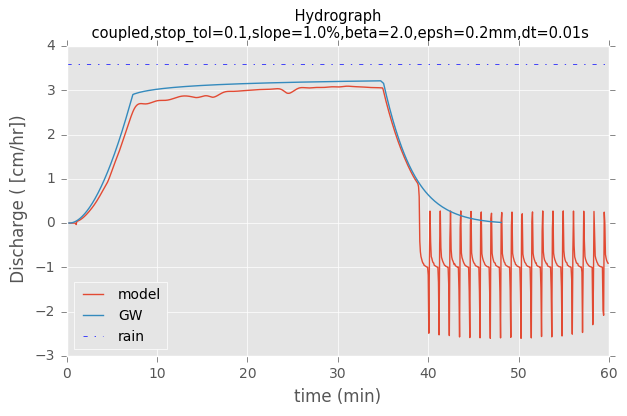

In [38]:

fig = plt.figure(figsize = (7, 4))
plt.plot(tp/60., - hydrop, '-', label = 'model')
if iscouple:
    plt.plot(tout/60., qout*scale/L, '-', label = 'GW')
else:
    plt.plot(tp/60., q0, '-', label = 'analytical')
    if np.any(abs((- hydrop - q0)*10)> abs(q0)):
        plt.plot(tp/60.,(- hydrop - q0), '-', alpha = .6, label = 'difference')
    else:
        plt.plot(tp/60.,(- hydrop - q0)*10, '-', alpha = .6, label = '10 x (difference)')
plt.axhline(rain*scale, ls = '-.', lw = .5, label = 'rain')
plt.title(' Hydrograph \n {0}'.format( fmtstr), fontsize = 10.5)
# plt.xlim(50,52.1); 
# plt.ylim(-.001,.001)
# plt.ylim(3., 3.7)
plt.xlabel('time (min)'); plt.ylabel(' Discharge ({0})'.format(ylabel))
plt.legend(fontsize = 10, loc= 'best')
fig.savefig('{0}/hydro_{1}.pdf'.format(subfolder, fmtstr))

In [39]:
flux1 = []
flux2 = []
flux3 = [] 
flux4 = []
f = open('{0}/allfluxes.out'.format(folder), 'r'); 
for line in f:
    a = (line.strip().split(" "))
    a = [myfloat(b) for b in a if b]
    flux1.append(a[0])
    flux2.append(a[1])
    flux3.append(a[2])
    flux4.append(a[3])
    
flux1 = -np.array(flux1)
flux2 = -np.array(flux2)
flux3 = -np.array(flux3)
flux4 = -np.array(flux4)

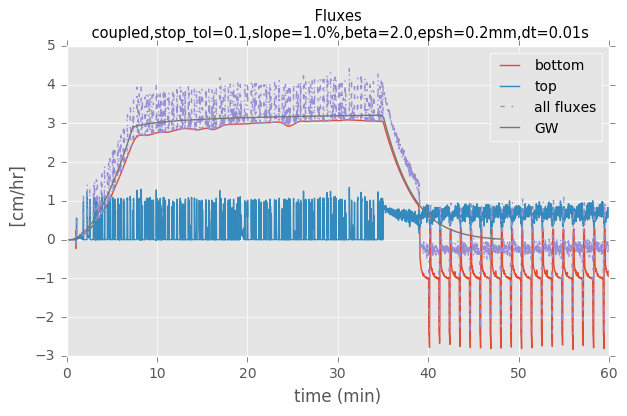

In [40]:
binfreq = 100
# convert m3/s to cm/hr
f1 = mybin(flux1, binfreq)/dt_sw/L/(ncol*dx)*3.6e5
f3 = mybin(flux3, binfreq)/dt_sw/L/(ncol*dx)*3.6e5

tdum = mybin(t_sw, binfreq)
t0 = int(np.where(tdum>0)[0][0])
t1 = int(np.where(tdum<=tmax)[0][-1])

fig = plt.figure(figsize = (7, 4))
plt.plot(tdum[t0:t1]/60., f1[t0:t1], '-', ms = 1, label = 'bottom')
plt.plot(tdum[t0:t1]/60., f3[t0:t1], '-', label = 'top')
plt.plot(tdum[t0:t1]/60., (f3+f1)[t0:t1], '-.', ms = 1, label = 'all fluxes')
if iscouple:
    plt.plot(tout/60., qout*scale/L, '-', label = 'GW')
else:
    plt.plot(tp[t0:t1]/60., q0[t0:t1], '--', label = 'analytical')
plt.title(' Fluxes \n {0}'.format( fmtstr), fontsize = 10.5)
plt.xlabel('time (min)'); plt.ylabel(' {0}'.format(ylabel))
plt.legend(fontsize = 10, loc= 'best')
# plt.ylim(-epsh*100,epsh*200); #plt.xlim(51, 52)
# plt.ylim(3.55,3.65)
fig.savefig('{0}/fluxes_{1}.pdf'.format(subfolder, fmtstr))

## SVE animations

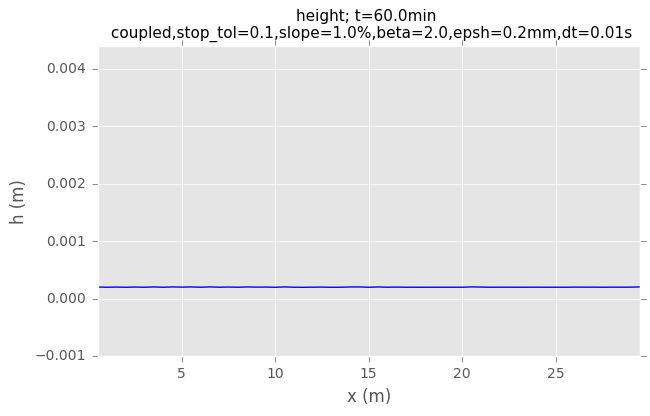

In [41]:
# plot h alone
hplot = (h[::10,:, :])
anim = 1
if anim:
    fig=plt.figure(figsize = (7, 4))
    yy = np.arange(0, nrow*dx, dx)
    col = 1
    zmin =  np.unique(h)[0] - 0.001
    zmax = np.unique(h)[-1] + 0.001
    x0 = 1
    ax = plt.axes(xlim=(yy[x0], yy[-1]), ylim=(zmin, zmax))
    img, = plt.plot(yy[x0:],  h[1][col, x0:], 'b-')
    ttl = ax.set_title('',animated=True, fontsize = 11)
    ax.xaxis.set_animated(True)
    plt.xlabel('x (m)'); plt.ylabel('h (m)')
    def init():
        ttl.set_text('') 
        img.set_data([0],[0])
        return img, ttl, ax.xaxis

    def func(n):
        ttl.set_text('height; t={0:.1f}min \n {1}'.format( tp[n]/60.*10,fmtstr))    
        img.set_data(yy[x0:], (hplot[n])[col, x0:])
        ax.set_xlim(yy[x0],yy[-1])
        return img, ttl, ax.xaxis

    ani = animation.FuncAnimation(fig,func,init_func=init,frames=len(hplot),
                                   interval=100,blit=True)

    ani.save('{0}/h_{1}.mp4'.format(subfolder, fmtstr))


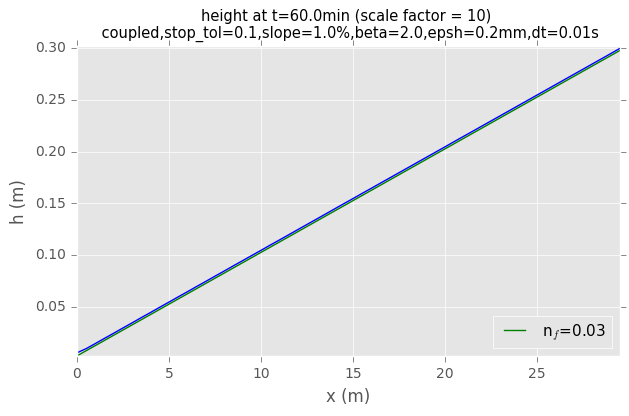

In [42]:
# plot h with z
anim = 1
hplot = (h[::10,:, :])*10

if anim:
    fig=plt.figure(figsize = (7, 4))
    yy = np.arange(0, nrow*dx, dx)
    col = 1
    zmin =  np.unique(hplot+zc)[1] - 0.001
    zmax = np.unique(hplot+zc)[-1] + 0.001

    ax = plt.axes(xlim=(0, yy[-1]+.1), ylim=(zmin, zmax))
    
    plt.plot(yy[:],  zc[col, :], 'g-', label = 'n$_f$={0}'.format(xni))
    img, = plt.plot(yy,  (zc +hplot[1])[col], 'b')
    ttl = ax.set_title('',animated=True, fontsize = 10.5)
    plt.legend(fontsize = 11, loc = 'lower right')
    ax.xaxis.set_animated(True)
    plt.xlabel('x (m)'); plt.ylabel('h (m)')
    def init():
        ttl.set_text('') 
        img.set_data([0],[0])
        return img, ttl, ax.xaxis
 
    def func(n):
        ttl.set_text('height at t={0:.1f}min (scale factor = 10) \n {1}'.format( tp[n]/60.*10,fmtstr))    
        img.set_data(yy, (zc + hplot[n])[col])
        ax.set_xlim(yy[0],yy[-1])
        return img, ttl, ax.xaxis

    ani = animation.FuncAnimation(fig,func,init_func=init,frames=len(hplot),
                                   interval=100,blit=True)


    cmd('mkdir {0}/anim'.format(folder))
    ani.save('{0}/zeta_{1}.mp4'.format(subfolder, fmtstr))


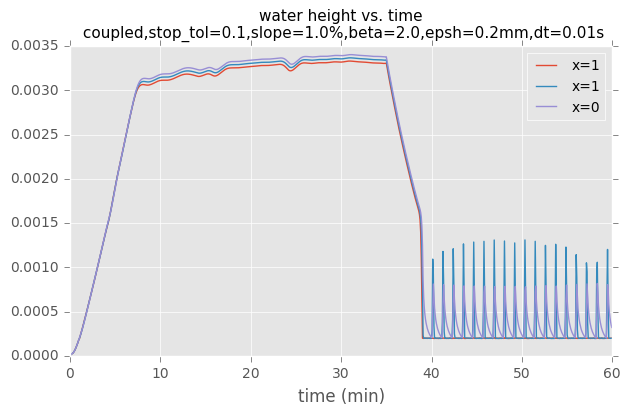

In [43]:
if case == 'GW':
    fig = plt.figure(figsize = (7, 4))
    yy = np.arange(nrow)
    col= 1; 
    plt.plot(tp/60.,  h[:-1,col, 2], '-', label = 'x={0:.0f}'.format(ycc[col, 2]))
    plt.plot(tp/60.,  h[:-1,col, 1], '-', label = 'x={0:.0f}'.format(ycc[col, 1]))
    plt.plot(tp/60.,  h[:-1,col, 0], '-', label = 'x={0:.0f}'.format(ycc[col, 0]))
    plt.legend(loc = 'best', fontsize = 10)
    plt.title('water height vs. time\n {0}'.format(fmtstr), fontsize=11)
    plt.xlabel('time (min)')
    #plt.ylim(0, epsh*2); plt.xlim(51, 52)
    fig.savefig('{0}/h_timeseries_{1}.pdf'.format(subfolder, fmtstr))

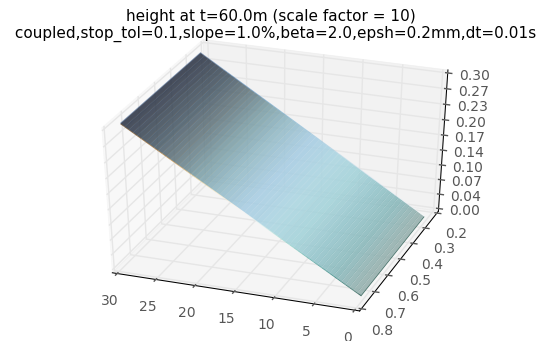

In [44]:
# 3D surface plot
anim =1
if anim:
    i = 0
    from matplotlib import cm
    from matplotlib.ticker import LinearLocator, FormatStrFormatter
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()

    hplot= 10*h[::10, :,:]
    ax = fig.add_subplot(111, projection='3d')

    ax.view_init(35, 110)
    ttl = ax.set_title('height at t={1:.1f}m (scale factor = 10) \n {0}'.format(
            fmtstr, tp[i]/60.*10),animated=True, fontsize = 10.)


    line = ax.plot_surface(ycc, xcc,
                        zc,
                        rstride=1, cstride=1,cmap=cm.BrBG_r,
                        linewidth=0,antialiased=True, alpha=0.4)
    def init():
        img.set_data([0],[0])
        return img, ttl, ax.xaxis

    def plotset(i):
        ax.patch.set_facecolor('white')
        ax.set_autoscalez_on(False)
        ax.zaxis.set_major_locator(LinearLocator(10))
        ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
        ax.set_zlim3d(np.min(zc[:, :]),np.max(hplot + zc) )
        ttl = ax.set_title('',animated=True, fontsize = 11)
        ttl.set_text('height at t={1:.1f}m (scale factor = 10) \n {0}'.format(
                fmtstr, tp[i]/60.*10))    
        return ttl

    def data(i, z, line):
        z = hplot[i]
        ax.clear()
        plotset(i)
        surf = ax.plot_surface(ycc, xcc, zc,rstride=1, 
                           cstride=1,cmap=cm.BrBG_r,
                           linewidth=0,antialiased=True, alpha=0.7)

        line = ax.plot_surface(ycc, xcc, zc+z,
                        rstride=1, cstride=1,cmap=cm.Blues,
                        linewidth=0,antialiased=True, alpha=0.5)
        return line, ttl, ax.xaxis


    ani = animation.FuncAnimation(fig, data, init_func = init, frames = len(hplot),
                                  fargs=(z, line), interval=100, blit=True)
    ani.save('{0}/h_surf_{1}.mp4'.format(subfolder, fmtstr))



In [45]:
if anim:
    display_animation(ani)


## Mass balance check

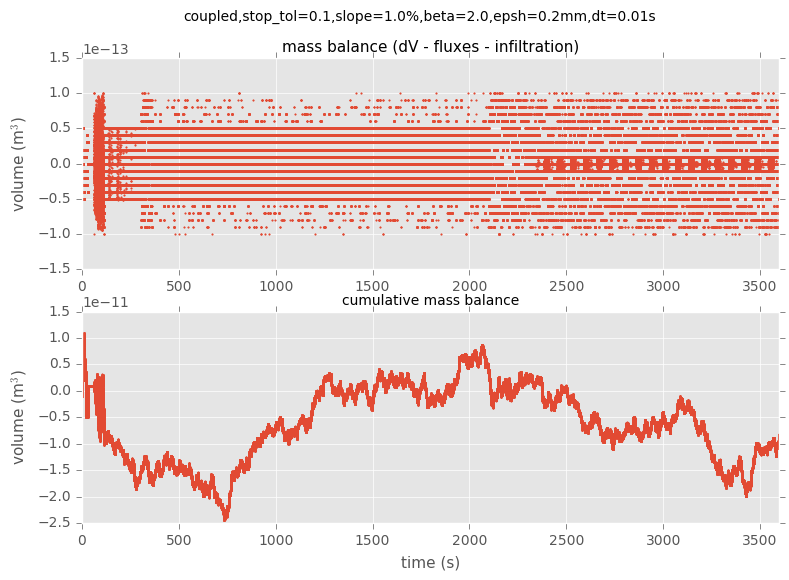

In [46]:
def get_dvol(folder):
    ta = []
    dvol = []
    infl = [] 
    flux = []
    rain = []
    dts = []
    f = open('{0}/dvol.out'.format(folder), 'r'); 
    for line in f:
        a = (line.strip().split(" "))
        a = [myfloat(b) for b in a if b]
        ta.append(a[0])
        dvol.append(a[1])
        flux.append(a[2])
        infl.append(a[3])
        rain.append(a[4])
        dts.append(a[5])
    ta = np.array(ta)
    dvol = np.array(dvol)
    flux = np.array(flux)
    infl = np.array(infl)
    rain = np.array(rain)    
    dts = np.array(dts)    
    total = dvol  - flux - infl - rain
    
    ti = 0; tf = len(ta)-1;  nprt = 1

    f = plt.figure(figsize= (9,6))
    plt.subplot(211)
    plt.plot(ta[ti:tf:nprt], dvol[ti:tf:nprt] - flux[ti:tf:nprt] - infl[ti:tf:nprt]
             - rain[ti:tf:nprt], '.', ms = 2)
    # plt.plot(ta[ti:tf:nprt], total[ti:tf:nprt], '.', ms = 2)
    plt.title('mass balance (dV - fluxes - infiltration)', fontsize = 11)
    plt.ylabel('volume (m$^3$)',fontsize = 11);
    plt.xlim([ta[ti], ta[tf]])
    plt.subplot(212)
    plt.plot(ta[ti:tf:nprt],np.cumsum(total)[ti:tf:nprt], '.', ms = 2)
    plt.title('cumulative mass balance', fontsize = 10)
    plt.xlabel('time (s)', fontsize = 11); 
    plt.ylabel('volume (m$^3$)',fontsize = 11);
    plt.xlim([ta[ti], ta[tf]])
    plt.suptitle('{0}'.format(fmtstr  ))
    
    return ta, dvol, flux, infl, rain, dts, total

tta, ddvol, fflux, iinfl, rrain, ddts, ttotal = get_dvol(folder = folder)


In [47]:
try:
    badind = np.where(abs(total)> 1e-11)[0][0]
    print badind
    print total[badind]/4
except:
    print 'no mass balance problems!'

no mass balance problems!



## Boundary condition weeds

In [55]:
solveUp = []

fdum = np.zeros(4) 
solveUp.append(fdum)
for line in open("{0}/{1}.out".format(folder,'solveUp'), 'r'):
    a = (line.strip().split(" "))
    a = [str(b) for b in a if b]        

    try: 
        fdum[0] = myfloat(a[0])
        fdum[1] = myfloat(a[1])
        fdum[2] = myfloat(a[2])
        fdum[3] = myfloat(a[3])      
    except:
        print a
    solveUp.append(fdum.copy())

solveUp = np.array(solveUp)
try:
    solveUp = mybin(solveUp, binfreq)
    tdum = mybin(solveUp[:, 0], binfreq)
except: 
    print 'zero depths'

In [ ]:
solveDown = []
fdum = np.zeros(3) 
solveDown.append(fdum)
for line in open("{0}/{1}.out".format(folder,'solveDown'), 'r'):
    a = (line.strip().split(" "))
    a = [str(b) for b in a if b]        

    try:
        fdum[0] = myfloat(a[0])
        fdum[1] = myfloat(a[1])
        fdum[2] = myfloat(a[2])
        fdum[3] = myfloat(a[3])       
    except:
        print a
    solveDown.append(fdum.copy())
solveDown = np.array(solveDown)
try:
    solveDown = mybin(solveDown, binfreq)
except: 
    print 'zero depths'


['2.0000000000000000E-002', '0.0000000000000000', '0.0000000000000000', '0.0000000000000000']
['2.9999999999999999E-002', '0.0000000000000000', '0.0000000000000000', '0.0000000000000000']
['4.0000000000000001E-002', '0.0000000000000000', '0.0000000000000000', '0.0000000000000000']
['5.0000000000000003E-002', '0.0000000000000000', '0.0000000000000000', '0.0000000000000000']
['6.0000000000000005E-002', '0.0000000000000000', '0.0000000000000000', '0.0000000000000000']
['7.0000000000000007E-002', '0.0000000000000000', '0.0000000000000000', '0.0000000000000000']
['8.0000000000000002E-002', '0.0000000000000000', '0.0000000000000000', '0.0000000000000000']
['8.9999999999999997E-002', '0.0000000000000000', '0.0000000000000000', '0.0000000000000000']
['9.9999999999999992E-002', '0.0000000000000000', '0.0000000000000000', '0.0000000000000000']
['0.10999999999999999', '0.0000000000000000', '0.0000000000000000', '0.0000000000000000']
['0.11999999999999998', '0.0000000000000000', '0.000000000000000

In [50]:
solveUp.shape

(3600, 3)

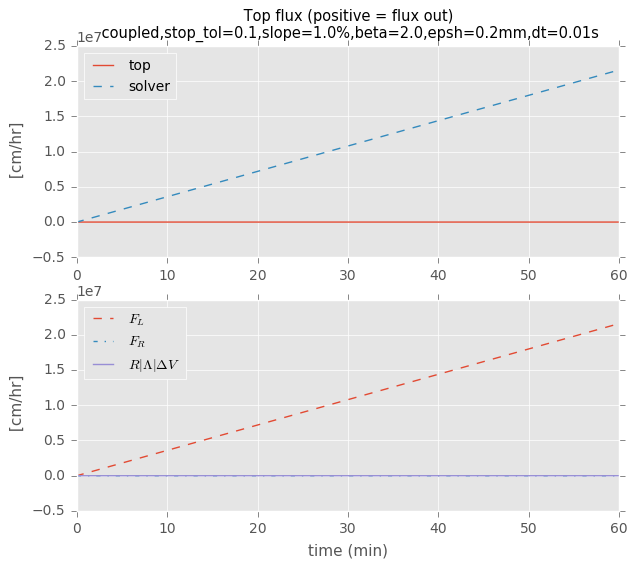

In [52]:
fig = plt.figure(figsize = (7, 6))
scale = 3600.*100


plt.subplot(211)
plt.title(' Top flux (positive = flux out) \n {0}'.format( fmtstr), fontsize = 10.5)
plt.plot(tdum[:]/60.,  f3, '-', label = 'top')
plt.plot(tdum[:]/60., 0.5*(solveUp[:, 0]+solveUp[:, 1]-
                            solveUp[:, 2])/L*scale,  '--', label ='solver')
plt.ylabel('{0}'.format(ylabel), fontsize = 11)
plt.legend(fontsize = 10, loc= 'best') 

plt.subplot(212)
plt.plot(tdum[:]/60., 0.5*(solveUp[:, 0] )/L*scale, '--', label = '$F_L$')
plt.plot(tdum[:]/60., 0.5*(solveUp[:, 1] )/L*scale, '-.', label = '$F_R$')
plt.plot(tdum[:]/60., 0.5*(solveUp[:, 2])/L*scale,'-', label = '$R |\Lambda| \Delta V$')

plt.xlabel('time (min)', fontsize = 11); 
plt.ylabel('{0}'.format(ylabel), fontsize = 11)
plt.legend(fontsize = 10, loc= 'best')
fig.savefig('{0}/flux3_{1}.pdf'.format(subfolder, fmtstr))

In [ ]:
fig = plt.figure(figsize = (7, 6))
scale = 3600.*100
plt.subplot(211)
plt.title(' Bottom flux  \n {0}'.format( fmtstr), fontsize = 10.5)
plt.plot(tdum[:]/60.,  f1[:], '--', label = 'top')
plt.plot(tdum[:]/60., - 0.5*(solveDown[:, 0]+solveDown[:, 1]-
                            solveDown[:, 2])/L*scale, '--', label ='solver')
plt.ylabel('{0}'.format(ylabel), fontsize = 10)

plt.subplot(212)
plt.plot(tdum[:]/60., -0.5*(solveDown[:, 0] )/L*scale, '--', label = '$F_L$')
plt.plot(tdum[:]/60., -0.5*(solveDown[:, 1] )/L*scale, '-.', label = '$F_R$')
plt.plot(tdum[:]/60., -0.5*(-solveDown[:, 2])/L*scale,'-', label = '$R |\Lambda| \Delta V$')

plt.xlabel('Time (min)', fontsize = 10); 
plt.ylabel('{0}'.format(ylabel), fontsize = 10)
plt.legend(fontsize = 10, loc= 'best')
fig.savefig('{0}/flux1_{1}.pdf'.format(subfolder, fmtstr))

In [ ]:
def read_downslope(folder=  folder, fname = 'down_h'):
    downslope = []
    fdum = np.zeros(5) 

    for line in open("{0}/{1}.out".format(folder, fname), 'r'):
        a = (line.strip().split(" "))
        a = [str(b) for b in a if b]        

        try:
            fdum[0] = myfloat(a[0])
            fdum[1] = myfloat(a[1])
            fdum[2] = myfloat(a[2])
            fdum[3] = myfloat(a[3])
            #fdum[4] = int(a[4])        
        except:
            print a
        downslope.append(fdum.copy())
    downslope = np.array(downslope)
    return downslope

In [ ]:
up_h = read_downslope(fname = 'up_h')

In [ ]:
t0 = int(np.where(t_sw>t_sw[0])[0][0])
t1 = int(np.where(t_sw>=t_sw[-1])[0][0])

ghost = up_h
tlow = t_sw
fig = plt.figure(figsize = (7, 6))
plt.subplot(211)
plt.title('Boundary values ', fontsize = 11)
plt.plot(tlow,  ghost[:,1] , '-', label = 'ghost x=0')
plt.plot(tlow,  ghost[:,2] , '-', label = 'x=1')
plt.plot(tlow,  ghost[:,3], '--',label = 'x=2')
# plt.axhline(epsh, c = 'k', lw = 0.5)
plt.legend(loc = 'best', fontsize = 10)
# plt.xlim(51, 51.6); plt.ylim(-epsh,epsh*3)

plt.subplot(212)
plt.plot(tlow, ghost[:, 2] - ghost[:, 1], '--', label = 'h(1)-h(0)')
plt.plot(tlow, ghost[:, 3] - ghost[:, 2], '-', label = 'h(2)-h(1)')
plt.legend(loc = 'best', fontsize = 10)
# fig.savefig('{0}/up_h_{1}.pdf'.format(subfolder, fmtstr))

### Check Richards  stand alone  version

In [ ]:
if case != 'GW':
    fig = plt.figure(1, figsize = (10,3.5)); 
    ax = plt.subplot(121)
    plt.subplots_adjust(wspace = .3)
    plt.xlabel('Pressure head [cm]',  fontsize = 10)
    plt.plot(hinit,z, label = 't=0'.format(t[0]), lw = 1.5)
    plt.ylabel('Depth [cm]',fontsize=  11)
    plt.xlim( np.min(H)-2,  np.max(H)+2)
    plt.title('Pressure head vs. depth', fontsize=  11)

    ax = plt.subplot(122)
    plt.xlabel('Soil moisture $cm^3/cm^3$',fontsize=  11)
    plt.ylabel('Depth [cm]',fontsize=  11)
    # plt.plot(thetainit,z, label = 't=0'.format(t[0]), lw = 1.5)
    plt.title('Soil moisture vs. depth',fontsize=  11)

    for i in np.arange(0, nt+1, nt/4, dtype = int)[1:]-1:
        ax = plt.subplot(121)
        plt.plot(H[:, i], z, label = '{0:.0f}'.format(t[i]), lw = 1.5)
        plt.legend(loc = 'best', fontsize = 10)
        ax = plt.subplot(122)
        plt.plot(THETA[:, i], z, label = '{0:.0f}'.format(t[i]), lw = 1.5)
        plt.legend(loc = 'best', fontsize = 10)
        plt.locator_params(nbins=4)
    title = plt.suptitle(fmtstr, fontsize = 10); title.set_y(1.01) 

In [ ]:
tt = []
depthf = []
for line in open("{0}/depth.out".format(folder), 'r'):
    a = (line.strip().split(" "))
    a = [float(b) for b in a if b]
    tt.append(a[0])
    depthf.append(a[1])
        
print len(tt)
tt[-1] = tmax
from scipy import interpolate

f = interpolate.interp1d(tt, depthf)
depthf = f(t)

In [ ]:
if case == 'richards':
    fig = plt.figure(1, figsize = (9,3.5)); 
    ax = plt.subplot(122)
    plt.subplots_adjust(wspace = .2)
    plt.plot(t/60., depthf*100 - depths, label = '{0:.3e}'.format(max(depthf*100 - depths)))
    plt.title('  water height:(fortran-python)', fontsize = 10)
    plt.ylabel('height (cm)',fontsize=  10)
    plt.xlabel('time',  fontsize = 10)
    plt.legend(loc = 'best', fontsize = 10)
    plt.locator_params(axis = 'x', nbins = 8) 

    plt.subplot(121)
    plt.plot(t/60., depthf*100, label = 'fortran')
    plt.plot(t/60., depths , '-', label = 'python')
    plt.title('water height '.format(fmtstr), fontsize = 10)
    plt.legend(loc = 'best', fontsize = 10)
    plt.locator_params(axis = 'x', nbins = 10) 
    plt.locator_params(nbins=4)
    plt.ylabel('height (cm)',fontsize=  10)
    plt.xlabel('time (min)',  fontsize = 10)
    title = plt.suptitle(fmtstr, fontsize = 10); title.set_y(1.02) 

In [ ]:
# code to check solution
t1 =  np.zeros([nz])

for line in open("{0}/test.out".format(folder), 'r'):
    a = (line.strip().split(" "))
    a = [float(b) for b in a if b]
    l = int(a[0])-1
    t1[l] = a[1]

In [ ]:
if case != 'GW':
    fig = plt.figure(1, figsize = (10,3.5)); 
    ax = plt.subplot(121)
    # plt.subplots_adjust(wspace = .3)
    diff = t1 - THETA[:, -1]
    plt.plot(diff,z, label = 'max error = {0:.4}'.format(max(abs(diff)))  )
    plt.title('Final theta: fortran - python difference \n {0}'.format(fmtstr), fontsize = 10)
    plt.ylabel('z [cm]',fontsize=  10)
    plt.xlabel('theta ',  fontsize = 10)
    plt.legend(loc = 'best', fontsize = 10)
    plt.locator_params(nbins=4)

    plt.subplot(122)
    plt.plot(THETA[:, -1],z, label = 'python')
    plt.plot(t1,z , label = 'fortran')
    plt.title('Final theta  \n {0}'.format(fmtstr), fontsize = 10)
    plt.legend(loc = 'best', fontsize = 10)
    plt.locator_params(nbins=4)


### More Richards error summary

In [ ]:
fluxin_for = []
fluxout_for = []
newmass_for = []
error_for = []
for line in open("{0}/soilfluxes.out".format(folder), 'r'):
    a = (line.strip().split(" "))
    a = [str(b) for b in a if b]        
    fluxin_for.append(float(a[1]))
    fluxout_for.append(float(a[2]))
    newmass_for.append(float(a[3]))
    error_for.append(float(a[4]))
    
fluxin_for = np.array(fluxin_for)
fluxout_for = np.array(fluxout_for)
newmass_for = np.array(newmass_for)
error_for = np.array(error_for)

In [ ]:
print 'fortran'
print 'cumulative error = {0:.2}cm/hr'.format( np.cumsum(fluxin_for - newmass_for + fluxout_for)[-1]/tmax*3600)
print 'cumulative surface flux = {0:.2}cm/hr'.format( np.cumsum(fluxin_for)[-1]/tmax*3600)
print 'cumulative error relative to surface flux = {0:.2f}% '.format( 
    np.cumsum(fluxin_for - newmass_for + fluxout_for)[-1]/np.cumsum(fluxin_for )[-1]*100)

In [ ]:
if case != 'GW':
    #  cumulative error
    fig = plt.figure(1, figsize = (7,3.))
    plt.title('Cumulative mass error  {0}'.format(fmtstr), fontsize = 10)
    plt.plot(t, np.cumsum(fluxin - newmass + fluxout ), '-', label =  'uncorrected')
    # plt.plot(t, np.cumsum(fluxin - newmass + fluxout - error), '-', label =  'corrected')
    # plt.plot(t, np.cumsum(fluxin_for - newmass_for + fluxout_for ), '-', label =  'uncorrected')
    # plt.plot(t, np.cumsum(fluxin_for - newmass_for + fluxout_for - error_for ), '-', label =  'uncorrected')


    plt.xlabel('time (s)'); plt.ylabel('error [cm]')
    plt.legend(loc = 'best', fontsize = 10)
    # fig.savefig('case_{1}/error {0}.pdf'.format(fmtstr, case))

In [ ]:
plotscale = 'depth'
if plotscale == 'rate':
    scale = 3600./dt
    ylabel = 'rate [cm/hr]'
elif plotscale == 'depth':
    scale = 1
    ylabel = 'cm'
    
# flux rates
if case != 'GW':
    fig = plt.figure(1, figsize = (7,3.7))
    plt.title('Mass balance components'.format(fmtstr), fontsize = 11)
    plt.plot(t, fluxout*scale, label = 'flux out')
    plt.plot(t, fluxin*scale, '-', ms = 1, label = 'flux in')
    plt.plot(t, error*scale, '-',  label = 'error')
    plt.plot(t[1:], newmass[1:]*scale, '-.', lw = 1, label = 'mass change')
    plt.legend(loc = 'best', fontsize = 10)
    plt.xlabel('time [s]') 
    plt.ylabel(ylabel)

    # fig.savefig('case_{1}/flux rates {0}.pdf'.format(fmtstr, case))

In [ ]:
if case == 'fixed_h':
    fig = plt.figure(1, figsize = (11,4)); 
    plt.subplot(122)
    Ksati = phi['ksat'][-1]
    S0i = .006
    plt.plot(t, fluxin/dt, label = 'Richards' )
    plt.plot(t, 0.5*S0i*t**(-.5) + Ksati,  label = 'Philips (with So = .006)' )
    plt.legend(loc = 'best',fontsize = 11)
    plt.title('Infiltration rates',fontsize = 11)

    plt.subplot(121)
    plt.plot(t, 2*(fluxin - Ksati)*t**.5)
    plt.title('Sorptivity estimate ', fontsize = 11)
